#### Bibliotecas utilizadas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 as cv
import hashlib

## Análise do arquivo CSV

##### Realizando a leitura do arquivo

In [3]:
df = pd.read_csv('dataset/metadata.csv')
df

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png
...,...,...,...,...
8565,998829,test,test/998829_sat.jpg,NaN
8566,998928,test,test/998928_sat.jpg,NaN
8567,999518,test,test/999518_sat.jpg,NaN
8568,999651,test,test/999651_sat.jpg,NaN


##### Separando a quantidade de validação, teste e treinamento

In [4]:
qtd_train = len(df[df['split'] == 'train'].index)
qtd_valid = len(df[df['split'] == 'valid'].index)
qtd_test = len(df[df['split'] == 'test'].index)

result = """
    Qtd de arquivos de treino: {train} * 2 (sat e mask)
    Qtd de arquivos de validação: {valid} (sat)
    Qtd de arquivos de teste: {test}  (sat)
    """
print(result.format(train=qtd_train, valid=qtd_valid, test=qtd_test))
print("Total de arquivos: ", qtd_train*2 + qtd_valid + qtd_test)


    Qtd de arquivos de treino: 6226 * 2 (sat e mask)
    Qtd de arquivos de validação: 1243 (sat)
    Qtd de arquivos de teste: 1101  (sat)
    
Total de arquivos:  14796


##### Plotando gráfico

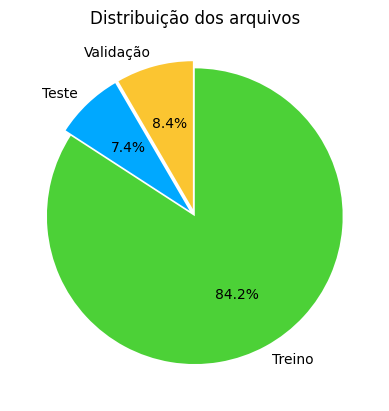

In [5]:
labels = ['Validação', 'Teste', 'Treino']
sizes = [qtd_valid, qtd_test, qtd_train*2]
fig, ax = plt.subplots()

colors = ['#fbc531', '#00a8ff', '#4cd137']

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05, 0), colors=colors)
plt.title('Distribuição dos arquivos')
plt.show()

## Análise do dataset

### Integridade dos arquivos
1. Verifique se todas as imagens listadas no arquivo de informações realmente existem no diretório de imagens e vice-versa.
2. Verifique se todas as imagens estão no mesmo formato, ex: JPEG, PNG, etc

##### Verificando os arquivos de treino (Pares correspondentes e extensão do arquivo)

In [12]:
def verificar_pares_e_extensoes(caminho_pasta):
    arquivos = os.listdir(caminho_pasta)

    masks = set()
    sats = set()

    extensoes_incorretas = {
        'mask': [],
        'sat': []
    }

# Percorre os arquivos da pasta verificando a terminação de cada um
    for arquivo in arquivos:
        if arquivo.endswith('_mask.png'):
            masks.add(arquivo.replace('_mask.png', ''))
        elif arquivo.endswith('_mask.jpg'):
            extensoes_incorretas['mask'].append(arquivo)
        elif arquivo.endswith('_sat.jpg'):
            sats.add(arquivo.replace('_sat.jpg', ''))
        elif arquivo.endswith('_sat.png'):
            extensoes_incorretas['sat'].append(arquivo)

# Vericação se há algum par faltando
    sem_pares_mask = masks - sats
    sem_pares_sat = sats - masks

# Se não houver arquivos sem pares ou com extensões incorretas: Tudo OK!
    if not sem_pares_mask and not sem_pares_sat and not extensoes_incorretas['mask'] and not extensoes_incorretas['sat']:
        print("Tudo OK!")
    else:
        # Exibe os arquivos com erros
        if sem_pares_mask:
            print("Os arquivos 'mask' não possuem correspondentes 'sat':")
            for arquivo in sem_pares_mask:
                print(f"{arquivo}_mask.png")
        if sem_pares_sat:
            print("Os arquivos 'sat' não possuem correspondentes 'mask':")
            for arquivo in sem_pares_sat:
                print(f"{arquivo}_sat.jpg")
        if extensoes_incorretas['mask']:
            print("Os arquivos 'mask' estão com extensões incorretas:")
            for arquivo in extensoes_incorretas['mask']:
                print(arquivo)
        if extensoes_incorretas['sat']:
            print("Os arquivos 'sat' estão com extensões incorretas:")
            for arquivo in extensoes_incorretas['sat']:
                print(arquivo)

caminho_pasta = 'dataset/train'
verificar_pares_e_extensoes(caminho_pasta)

Tudo OK!


##### Verificando extensão dos arquivos de teste e de validação

In [13]:
def verificar_extensao_sat(caminho_pasta):

    arquivos = os.listdir(caminho_pasta)
    extensoes_incorretas = []

# Percorre os arquivos da pasta verificando suas terminações
    for arquivo in arquivos:
        if not arquivo.endswith('_sat.jpg'):
          # Add na lista o arquivo com extensão incorreta
            extensoes_incorretas.append(arquivo)

    if not extensoes_incorretas:
        print("Tudo OK")
    else:
        print("Os arquivos não possuem o final '_sat.jpg':")
        for arquivo in extensoes_incorretas:
            print(arquivo)

caminho_pasta = 'dataset/test'
# caminho_pasta = 'dataset/valid'
verificar_extensao_sat(caminho_pasta)

Tudo OK


### Consistência dos Metadados

1. Verifique valores inconsistentes, por exemplo: dimensões de imagens fora do esperado.

In [14]:
def verificar_dimensoes(caminho_pasta, shape_esperado):
    arquivos = os.listdir(caminho_pasta)
    dimens_incorretas = []

# Percorrendo arquivos e verificando a dimensão de cada imagem
    for arquivo in arquivos:
        caminho_arquivo = os.path.join(caminho_pasta, arquivo)
        imagem = cv.imread(caminho_arquivo)
        if imagem.shape != shape_esperado:
            dimens_incorretas.append(arquivo)

    if not dimens_incorretas:
        print("Tudo OK!")
    else:
        print("Os arquivos possuem dimensões diferentes: ")
        for arquivo in dimens_incorretas:
            print(arquivo)

caminho_pasta = 'dataset/test'
# caminho_pasta = 'dataset/valid'
# caminho_pasta = 'dataset/train'
shape_esperado = (1024, 1024, 3)
verificar_dimensoes(caminho_pasta, shape_esperado)

Tudo OK!


### Qualidade das Imagens

1. Identifique imagens corrompidas que não podem ser abertas ou processadas

In [18]:
def imagens_corrompidas(caminho_pasta):
    arquivos = os.listdir(caminho_pasta)

    imagens_corrompidas = []

    for arquivo in arquivos:
        caminho_arquivo = os.path.join(caminho_pasta, arquivo)
        try:
            imagem = cv.imread(caminho_arquivo)
            if imagem is None:
                raise ValueError("Arquivo não pôde ser aberto ou está vazio")
        except Exception as e:
            imagens_corrompidas.append(arquivo)
            print(f"Imagem corrompida: {arquivo} - {str(e)}")

    if imagens_corrompidas:
        print("\nImagens corrompidas:")
        for imagem in imagens_corrompidas:
            print(imagem)
    else:
        print("\nTudo Ok")

caminho_pasta = 'dataset/test'
# caminho_pasta = 'dataset/valid'
# caminho_pasta = 'dataset/train'
imagens_corrompidas(caminho_pasta)


Tudo Ok


### Duplicatas

1. Identifique imagens duplicadas que possam enviesar os resultados.
2. Verifique duplicatas no arquivo de informações.

In [20]:
import hashlib

# Gera um hash para cada arquivo baseado no conteúdo binário
def calcular_hash_md5(arquivo):
    with open(arquivo, 'rb') as f:
        conteudo = f.read()
        hash_md5 = hashlib.md5(conteudo).hexdigest()
    return hash_md5

def imagens_duplicadas(caminho_pasta):
    arquivos = os.listdir(caminho_pasta)

    hash_arquivos = {}
    duplicatas = []

# Percorre todos os arquivos verificando o hash gerado de cada arquivo
    for arquivo in arquivos:
        caminho_arquivo = os.path.join(caminho_pasta, arquivo)
        hash_md5 = calcular_hash_md5(caminho_arquivo)
        if hash_md5 in hash_arquivos:
            duplicatas.append((arquivo, hash_arquivos[hash_md5]))
        else:
            hash_arquivos[hash_md5] = arquivo

    if duplicatas:
        print("Imagens duplicadas:")
        for imagem1, imagem2 in duplicatas:
            print(f"Imagem 1: {imagem1} & Imagem 2: {imagem2}")
    else:
        print("Tudo Ok!")

caminho_pasta = 'dataset/test'
# caminho_pasta = 'dataset/valid'
# caminho_pasta = 'dataset/train'
imagens_duplicadas(caminho_pasta)


Tudo Ok!
